In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import trange
import torch
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from IPython.display import Image, display
import PIL.Image
import io
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertModel, BertTokenizerFast

# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [4]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/keyan/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


Some weights of the model checkpoint at uclanlp/visualbert-vqa-coco-pre were not used when initializing VisualBertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# use frcnn to get the visual embeddings
def get_visual_embeddings(image):      
    # image = str(image)  
    images, sizes, scales_yx = image_preprocess(image)
    output_dict = frcnn(
        images,
        sizes,
        scales_yx=scales_yx,
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
    )
    features = output_dict.get("roi_features")

    return features

In [76]:
def get_inputs(images):
    visual_embeds, visual_attention_mask, visual_token_type_ids = [], [], []
    for img in images:
        visual_embed = get_visual_embeddings(img)[0].unsqueeze(0)
        visual_embeds.append(visual_embed)
        visual_token_type_ids.append(torch.ones(visual_embed.shape[:-1], dtype=torch.long))
        visual_attention_mask.append(torch.ones(visual_embed.shape[:-1], dtype=torch.float))
    # convert the lists to tensors
    visual_embeds = torch.cat(visual_embeds, dim=0)
    visual_token_type_ids = torch.cat(visual_token_type_ids, dim=0)
    visual_attention_mask = torch.cat(visual_attention_mask, dim=0)
    # visual_embeds = get_visual_embeddings(images)[0].unsqueeze(0)
    # visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    # visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

    return visual_embeds, visual_attention_mask, visual_token_type_ids

In [7]:
# Read the data
train = pd.read_csv('../memes_train.csv')
test = pd.read_csv('../memes_test.csv')
print('training dataset: ', train.shape)
print('testing dataset: ', test.shape)

training dataset:  (6625, 10)
testing dataset:  (1657, 10)


In [8]:
# add the relatived path to the image
train['image_path'] = '../' + train['image_path']
test['image_path'] = '../' + test['image_path']

In [9]:
# use cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# define the classifier
model = model.to(device)
vs_embed_dim = 768  
n_classes = 2        # number of classes for my dataset
classifier = nn.Linear(vs_embed_dim, n_classes)

In [20]:
# prepare the dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import requests

class MemeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # read the data from the dataframe
        row = self.df.iloc[idx]
        image = row['image_path']
        url = row['image_url']
        # image = Image.open(image).convert('RGB')
        # if self.transform:
        #     image = Image.open(image).convert('RGB')
        #     image = self.transform(image)        
        text = str(row['image_text'])
        # date = row['created_at']
        label = row['label']

        # prepare the embeddings to save time
        # visual_embeds, visual_attention_mask, visual_token_type_ids = get_inputs(image)

        return image, text, label, url

# define transforms
transform = {
        'train' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(50),
                                      transforms.ToTensor()]),

        'valid' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
        }


In [77]:
# splite the training set into train and valid
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)
# get 2000 samples for training, 500 for validation
random_state = 21
train_df = train_df.sample(n=2000, random_state=random_state)
valid_df = valid_df.sample(n=200, random_state=random_state)

print('training dataset: ', train_df.shape)
print('validation dataset: ', valid_df.shape)

training dataset:  (1000, 10)
validation dataset:  (200, 10)


In [78]:
# load the dataset
train_dataset = MemeDataset(train_df)
valid_dataset = MemeDataset(valid_df)
test_dataset = MemeDataset(test)

In [79]:
# define the dataloader
batch_size = 32
num_workers = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, num_workers=num_workers, shuffle=False)

In [80]:
# define the fine-tune function
from tqdm import tqdm
def fine_tune_vsbert(model,     # the model to fine-tune
                  classifier,  # single-layer fully-connected classifier
                  dataloaders, # dict with 2 keys, "train" and "valid", containing train & valid dataloaders
                  n_epochs,    # number of epochs to fine-tune
                  lr,          # learning rate
                  multi_label_data=False
                  ):
  
  model.to(device)
  classifier.to(device)

  #  1. Define optimizers and loss function  
  optimizer_encoder = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_classifier = optim.Adam(classifier.parameters(), lr=lr, betas=(0.5, 0.9))
  ### Different loss criterion for multi-label and single-label data
  if multi_label_data:
    criterion = nn.BCEWithLogitsLoss().to(device)
  else: # single-label data (standard)
    criterion = nn.CrossEntropyLoss().to(device)
  
  train_losses, val_losses, val_accs = [], [], []
  for e in trange(n_epochs, desc="Epoch"):
    #  2. Train on training data  
    model.train()
    classifier.train()
    train_loss = 0.
    for batch_i, (images, text, label, url) in tqdm(enumerate(train_loader)):
      #  3. Forward pass
      inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
      visual_embeds, visual_attention_mask, visual_token_type_ids = get_inputs(images)
      inputs.update(
          {
              "visual_embeds": visual_embeds,
              "visual_token_type_ids": visual_token_type_ids,
              "visual_attention_mask": visual_attention_mask,
          }
      )
      inputs = inputs.to(device)
      # print("input loaded")
      outputs = model(**inputs)
      logits = classifier(outputs.pooler_output) #get the predictions 
      # print("logits get")
      optimizer_encoder.zero_grad()
      optimizer_classifier.zero_grad()

      label = label.to(device)
      if multi_label_data:
        loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
      else:
        loss = criterion(logits.squeeze(-1).to(device), label)

      loss.backward()
      optimizer_encoder.step()
      optimizer_classifier.step()
      train_loss += loss.item()
      print(f"For batch {batch_i+1}/{len(train_loader)}.. "
            f"Train loss: {loss.item():.3f}.. ")
    train_losses.append(train_loss/len(train_loader))
    print(f"Epoch {e+1}/{n_epochs}.. "
          f"Train loss: {train_loss/len(train_loader):.3f}.. ") 
    # clean the cache
    # torch.cuda.empty_cache()

    #  3. Evaluate on valdiation data  
    model.eval()
    classifier.eval()
    val_loss = 0.
    for batch_i, (val_images, val_text, val_label, val_url) in enumerate(valid_loader):
      # image = Image.open(img)
      val_inputs = tokenizer(val_text, return_tensors="pt", padding=True, truncation=True)
      visual_embeds, visual_attention_mask, visual_token_type_ids = get_inputs(val_images)
      val_inputs.update(
          {
              "visual_embeds": visual_embeds,
              "visual_token_type_ids": visual_token_type_ids,
              "visual_attention_mask": visual_attention_mask,
          }
      )
      val_inputs = val_inputs.to(device)

      val_label = val_label.to(device)
      with torch.no_grad():
        outputs = model(**val_inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
        loss = criterion(logits.squeeze(-1).to(device), val_label)
        val_loss += loss.item()
    
    #  4. Log results and save model checkpoints 
    print("Epoch: {}/{}   Val CE Loss: {:.5f}".format(e+1, n_epochs, val_loss/len(valid_loader)))
    val_losses.append(val_loss/len(valid_loader))
    # save the best model
    # if val_loss/len(valid_loader) < min(val_losses):
    #   torch.save(model.state_dict(), '../models/vsbert_encoder.pt')
    #   torch.save(classifier.state_dict(), '../models/vsbert_classifier.pt')
    

    # save the checkpoint
    torch.save({
            'epoch': e+1,
            'encoder_state_dict': model.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_encoder_state_dict': optimizer_encoder.state_dict(),
            'optimizer_classifier_state_dict': optimizer_classifier.state_dict(),
            'loss': loss,
            }, '../models/vsbert.pt')

  return model, classifier

In [ ]:
# fine-tune the model
model, classifier = fine_tune_vsbert(model, 
                                    classifier, 
                                    n_epochs=5, 
                                    lr=3e-6,
                                    dataloaders={'train': train_loader, 'valid': valid_loader}
                                    )

In [ ]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

tp, fp, tn, fn = 0, 0, 0, 0
y_true = []
y_pred = []

model.eval()
classifier.eval()
test_loss = 0.

for batch_i, (test_image, test_text, test_label) in enumerate(test_loader):
    # inputs = processor(test_images, test_text, return_tensors="pt", padding=True, truncation=True).to(device)
    inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True)
    visual_embeds, visual_attention_mask, visual_token_type_ids = get_inputs(test_image)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    inputs = inputs.to(device)

    test_label = test_label.to(device)
    with torch.no_grad():
        # embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # generate predictions
        probs = torch.sigmoid(logits)
        scores = probs[:,1]
        preds = torch.argmax(logits, dim=1)
        # print(preds)
        # print(test_label)
        print('The number of correct predictions: ', (preds == test_label).sum().item(), '/', len(preds))
        # break
        
    # get the accuracy
    for i in range(len(preds)):
        if preds[i] == 1 and test_label[i] == 1:
            tp += 1
        elif preds[i] == 0 and test_label[i] == 0:
            tn += 1
        elif preds[i] == 1 and test_label[i] == 0:
            fp += 1
        else:
            fn += 1   
    
    for i in range(len(scores)):
        y_true.append(test_label[i].item())
        y_pred.append(scores[i].item())

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

In [ ]:
# save the results
import pandas as pd
df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
df.to_csv('../results/vsbert_roc.csv', index=False)
df = pd.DataFrame({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}, index=[0])
df.to_csv('../results/vsbert_cm.csv', index=False)

In [4]:
df_cm = pd.read_csv('../results/vsbert_cm.csv')

In [5]:
tp = df_cm['tp'][0]
fp = df_cm['fp'][0]
tn = df_cm['tn'][0]
fn = df_cm['fn'][0]

In [6]:
# print the evaluation metrics in a table
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Metric", "Value"]
x.add_row(["Accuracy", (tp+tn)/(tp+tn+fp+fn)])
x.add_row(["Precision", tp/(tp+fp)])
x.add_row(["Recall", tp/(tp+fn)])
x.add_row(["F1 Score", 2*tp/(2*tp+fp+fn)])
print(x)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.6541943270971635 |
| Precision | 0.6021634615384616 |
|   Recall  | 0.6742934051144011 |
|  F1 Score | 0.6361904761904762 |
+-----------+--------------------+


In [7]:
df_layout = pd.read_csv('../results/layoutlm_roc.csv')
df_vilt = pd.read_csv('../results/vilt_roc.csv')
df_vsbert = pd.read_csv('../results/vsbert_roc.csv')

In [8]:
# get the lists of fpr, tpr, thresholds
fpr_layout = df_layout['fpr'].tolist()
tpr_layout = df_layout['tpr'].tolist()
thresholds_layout = df_layout['thresholds'].tolist()

fpr_vilt = df_vilt['fpr'].tolist()
tpr_vilt = df_vilt['tpr'].tolist()
thresholds_vilt = df_vilt['thresholds'].tolist()

fpr_vs = df_vsbert['fpr'].tolist()
tpr_vs = df_vsbert['tpr'].tolist()
thresholds_vs = df_vsbert['thresholds'].tolist()

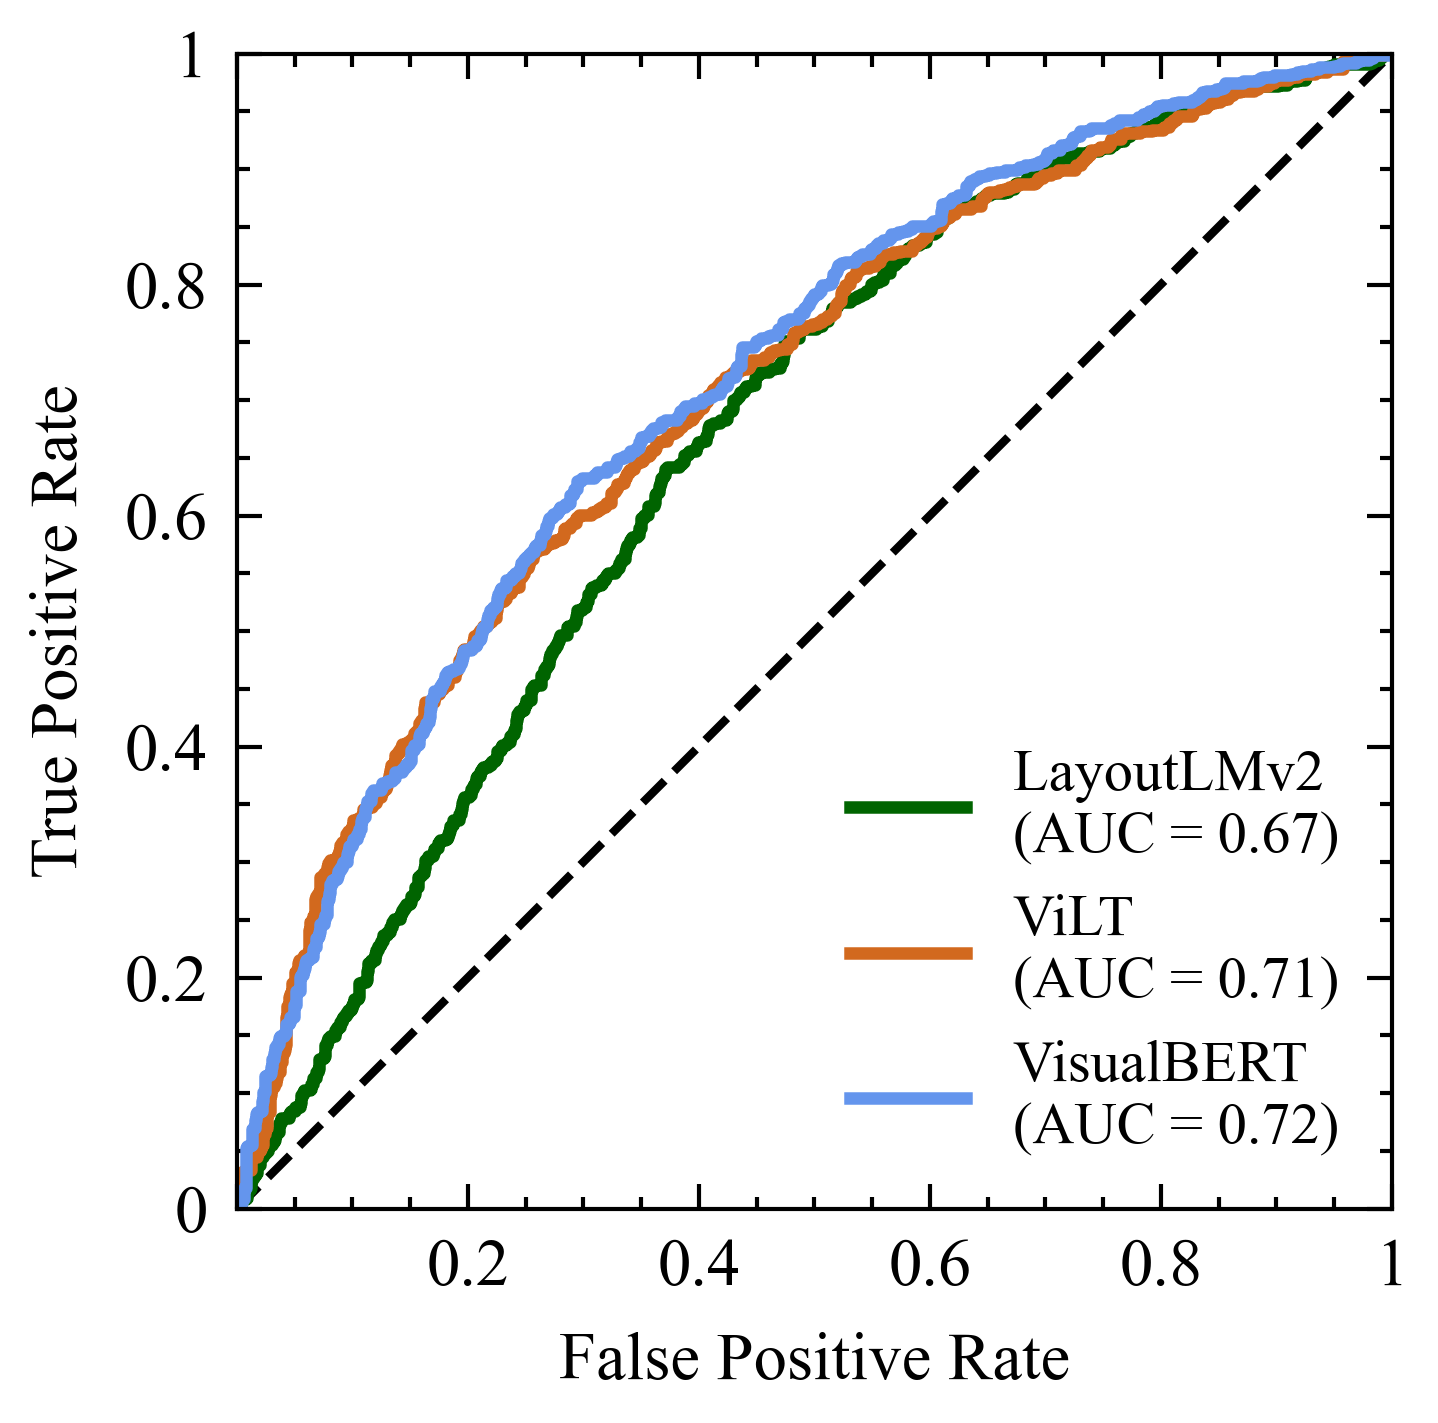

In [43]:
# create the figure
import latex
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use(['science','ieee', 'no-latex'])

plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": ["Times New Roman"],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Times New Roman"],
})

# resize the figure
# plt.rcParams['figure.figsize'] = [3, 2.5]

# plot the roc curve
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

ax.plot(fpr_layout, tpr_layout, color='darkgreen', label='LayoutLMv2 \n(AUC = %0.2f)' % auc(fpr_layout, tpr_layout), linestyle='-', linewidth=1.5)

ax.plot(fpr_vilt, tpr_vilt, color='chocolate', label='ViLT \n(AUC = %0.2f)' % auc(fpr_vilt, tpr_vilt), linestyle='-', linewidth=1.5)

ax.plot(fpr_vs, tpr_vs, color='cornflowerblue', label='VisualBERT \n(AUC = %0.2f)' % auc(fpr_vs, tpr_vs), linestyle='-', linewidth=1.5)

# remove the margin
ax.margins(0)

# set the axis labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# replace 0.0 with 0 and 1.0 with 1
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['', '0.2', '0.4', '0.6', '0.8', '1'])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])

# add 0 axis at the left bottom and 1 axis at the right top

# make square
ax.set_aspect('equal')

# change the lengend box size
ax.legend(loc='lower right', prop={'size': 7}, frameon=False)


# save the figure
plt.savefig('roc_curve.pdf', bbox_inches='tight')